In [8]:
using Plots
using DataFrames, CSV
import Base: @kwdef

using Turing
using Distributions, StatsPlots
using DataFrames

In [10]:
using PyCall
@pyimport surp
@pyimport vice

In [11]:
surp.yields.set_yields()

yields set to Magg et al. 2022 abundances
Yield settings
X        Z_solar    CC                             agb                            SN Ia                          

c        3.39e-03   2.28e-03 + 4.40e-02 (Z - Z0)   1.50 × cristallo11             0                              

n        1.04e-03   5.00e-04                       5.02e-04 M Z/Z0                0                              

o        7.33e-03   7.13e-03                       0                              0                              

mg       6.71e-04   6.52e-04                       0                              0                              

fe       1.37e-03   4.73e-04                       0                              7.70e-04                       



total c yield
y0_agb  0.00038
z0_agb  -0.01
agb_model:  cristallo11
0.002850 + 0.029000 (Z-Zo)
f_agb = 0.2000




In [12]:
subgiants = surp.subgiants

PyObject                                                          FILE  ... high_alpha
APOGEE_ID                                                      ...           
b'2M00002185+1459100'  b'apStar-dr17-2M00002185+1459100.fits'  ...      False
b'2M00004159+6505249'  b'apStar-dr17-2M00004159+6505249.fits'  ...      False
b'2M00004251+5643075'  b'apStar-dr17-2M00004251+5643075.fits'  ...      False
b'2M00005728+6958488'  b'apStar-dr17-2M00005728+6958488.fits'  ...       True
b'2M00012854+7021553'  b'apStar-dr17-2M00012854+7021553.fits'  ...      False
...                                                       ...  ...        ...
b'2M23582628+5524124'  b'apStar-dr17-2M23582628+5524124.fits'  ...      False
b'2M23582727+5606296'  b'apStar-dr17-2M23582727+5606296.fits'  ...      False
b'2M23590547+1514580'  b'apStar-dr17-2M23590547+1514580.fits'  ...      False
b'2M23594577-7351233'  b'asStar-dr17-2M23594577-7351233.fits'  ...       True
b'2M23594945+1445256'  b'apStar-dr17-2M23594945+1445256.fits'  ...       True

[14623 rows x 359 columns]

In [13]:
ϵ(t) = exp(-t)
ξ(t) = t * exp(-t)

ξ (generic function with 1 method)

In [14]:
calc_ϖ(params) = params.τ_star / (1 + params.η - params.r)

calc_ϖ (generic function with 1 method)

In [15]:
R = Real

Real

In [16]:
@kwdef struct Params
    η::R = 0.5
    r::R = 0.4
    τ_star::R = 2
        
    t_d_agb::R = 0.1
    τ_agb::R = 0.3
        
    y_c_agb::R = 0.000456

    y_c_cc::R = 2.28e-03
    ζ_c_agb::R = 0
    ζ_c_cc::R = 0
        
    y_o::R = 7.13e-03
    y_fe_cc::R = 4.73e-04
    y_fe_ia::R = 7.70e-04
        
    τ_ia::R = 1.5
    κ_ia::R = -1
    t_d_ia::R = 0.15
        
    t_end::R = 13.2
end

Params

In [17]:
function cc_model(t, y, params = Params())
    ϖ = calc_ϖ(params)
    s = @. 1 - ϵ(ϖ * t)
    return @. y / params.τ_star * s / ϖ
end

cc_model (generic function with 2 methods)

In [18]:
function fe_ia_model(t, params = Params())
    ϖ = calc_ϖ(params)
    ι = 1 / params.τ_ia
    
    δt = @. t - params.t_d_ia
    
    s = @. 1 - ϖ/(ϖ - ι) * ϵ(ι * δt)
    s .+= @. ι/(ϖ - ι) * ϵ(ϖ * δt)
    s = ifelse.(δt .<= 0, 0, s)
    
    Zeq = params.y_fe_ia / params.τ_star  / ϖ
    return Zeq .* s
end



function fe_model(t, params=Params())
    Zcc = cc_model(t, params.y_fe_cc, params)
    Zia = fe_ia_model(t, params)
    return Zcc + Zia
end


fe_model (generic function with 2 methods)

In [19]:
function c_agb_model(t, params=Params())
    α = 1/params.τ_agb
    ϖ = calc_ϖ(params)
    δt = t .- params.t_d_agb
    
    s = 1 / ϖ 
    s = @. s +  1/(α - ϖ) * ξ(α * δt)
    s .+= @. (2*α- ϖ) / (α - ϖ)^2 * ϵ(α * δt)
    s .+=  @. -(1/ϖ + (2*α- ϖ) / (α - ϖ)^2) * ϵ(ϖ * δt)
    
    s = ifelse.(δt .< 0, 0, s)

    return @. params.y_c_agb * s / params.τ_star
end

function c_model(t, params=Params())
    Zcc = cc_model(t, params.y_c_cc, params)
    Zia = c_agb_model(t, params)
    return Zcc .+ Zia
end


function o_model(t, params=Params())
    Zcc = cc_model(t, params.y_o, params)
    return Zcc 
end

o_model (generic function with 2 methods)

# mcmc fit to caah

In [14]:
@model function linear_regression(x, y, σ_y)
    # Priors
    α ~ Normal(0, 1)
    β ~ Normal(0, 0.5)
    
    # Likelihood
    for i in 1:length(y)
        y[i] ~ Normal(α + β * x[i], σ_y[i])
    end
end

linear_regression (generic function with 2 methods)

In [41]:
vice.yields.ccsne.settings("mg")

0.000652

In [43]:
x = surp.gce_math.MH_to_Z(subgiants.MG_H)
y = surp.gce_math.brak_to_abund(subgiants.C_MG, "C", "mg") * vice.yields.ccsne.settings("mg")
σ_y = @. subgiants.C_MG_ERR.values  * y / log(10); # TODO: double check this is correct error prop!

filt = (!).(isnan.(x))
filt .&= (!).(isnan.(y))
filt .&= (!).(isnan.(σ_y))
filt .&= (!).(subgiants.high_alpha.values)

x = x[filt]
y = y[filt]
σ_y = σ_y[filt];

In [44]:
model = linear_regression(x, y, σ_y)
chain = sample(model, NUTS(0.65), 2000)

┌ Info: Found initial step size
└   ϵ = 7.62939453125e-7
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:50


Chains MCMC chain (2000×14×1 Array{Float64, 3}):

Iterations        = 1001:1:3000
Number of chains  = 1
Samples per chain = 2000
Wall duration     = 65.5 seconds
Compute duration  = 65.5 seconds
parameters        = α, β
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters      mean       std      mcse   ess_bulk   ess_tail      rhat   e ⋯
      Symbol   Float64   Float64   Float64    Float64    Float64   Float64     ⋯

           α    0.0023    0.0000    0.0000   357.9654   504.1920    1.0026     ⋯
           β    0.0221    0.0000    0.0000   305.5147   425.7866    1.0048     ⋯
                                                                1 column omitted

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
      Symbol   Float64   Float64   Float64   Float64   Float64 

          

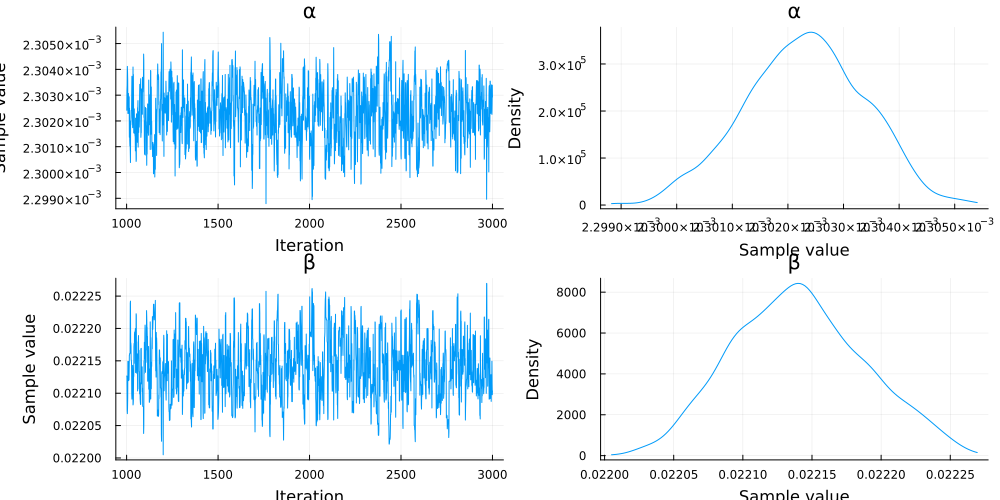

In [45]:
plot(chain)

In [46]:
p = plot()
xs = LinRange(0, 2, 1000)

for i in 1:10:length(chain)
    α = chain[:α].data[i]
    β = chain[:β].data[i]
    
    ys = @. α + xs * β
    plot!(xs, ys, color="black", alpha=0.05, lw=1, legend=false)
end

scatter!(x, y, ms=1, msw=0, alpha=0.5)

xlims!(0, 0.05)
ylims!(0, 1e-2)
p

# CAAFE Regression

In [20]:
function abund_to_brak(abundances, ele, ele2="h")
    Zo_a = vice.solar_z(ele)
    if ele2 == "h"
        return @. log10(abundances / Zo_a)
    else
        Zo_b = vice.solar_z(ele2)
        return @. log10(abundances) - log10(Zo_a / Zo_b)
    end
end

abund_to_brak (generic function with 2 methods)

In [21]:
function calc_model(params, t=vec(LinRange(0.01, 13, 1000)))
    zo_a = o_model(t, params)
    zfe_a = fe_model(t, params)
    zc_a = c_model(t, params)

    o_h_a = abund_to_brak(zo_a, "o")
    c_o_a = abund_to_brak(zc_a ./ zo_a, "c", "o")
    o_fe_a = abund_to_brak(zo_a ./ zfe_a, "o", "fe")
    
    return o_fe_a, c_o_a, ones(length(t))
        
end

calc_model (generic function with 2 methods)

In [113]:
function log_L(x, y, δx, δy, params)
    if x === missing
        return 0
    end
    
    x_pred, y_pred, w = calc_model(params)
    
    x_pred = reshape(x_pred, (1, :))
    y_pred = reshape(y_pred, (1, :))
    w = reshape(w, (1, :))

    χ2 = @. sqrt( (x - x_pred)^2/δx^2 + (y - y_pred)^2/δy^2  )
    s = @. w * exp(-χ2 / 2)
    
    Σ1 = sum(w .* s; dims=2)  # sum over each model prediction
    
    ll = sum( log.(Σ1) ) # product for each data point
    return ll
end

log_L (generic function with 1 method)

In [136]:
@model function singlezone_regression(x, y, σ_x, σ_y)
    # Priors
    ζ_c = 0
    
    t_d_agb ~ LogNormal(log(0.1), 0.4)
    f_agb ~ Beta(1, 1.5)
    τ_agb ~ LogNormal(log(0.3), 0.1)
    params = to_params(f_agb=f_agb, τ_agb=τ_agb, t_d_agb=t_d_agb)
    
    
    Turing.@addlogprob! log_L(x, y, σ_x, σ_y, params)
    
    y_c_tot = 2.3e-3

    y_c_cc = (1-f_agb) * y_c_tot
    y_c_agb = f_agb * y_c_tot
    
    return  y_c_cc, y_c_agb
end


model_params = [:f_agb, :τ_agb, :t_d_agb]
function to_params(; f_agb, τ_agb, t_d_agb)
    y_c_tot = 2.3e-3

    y_c_cc = (1-f_agb) * y_c_tot
    y_c_agb = f_agb * y_c_tot
    return Params(t_d_agb=t_d_agb, y_c_cc=y_c_cc, y_c_agb=y_c_agb, τ_agb=τ_agb)
end

to_params (generic function with 2 methods)

## Sample the prior

In [130]:
chain = sample(singlezone_regression(missing, missing, missing, missing), Prior(), 100)

Chains MCMC chain (100×4×1 Array{Float64, 3}):

Iterations        = 1:1:100
Number of chains  = 1
Samples per chain = 100
Wall duration     = 0.25 seconds
Compute duration  = 0.25 seconds
parameters        = t_d_agb, f_agb, τ_agb
internals         = lp

Summary Statistics
  parameters      mean       std      mcse   ess_bulk   ess_tail      rhat   e ⋯
      Symbol   Float64   Float64   Float64    Float64    Float64   Float64     ⋯

     t_d_agb    0.3418    0.1609    0.0166    94.1967    78.3393    1.0275     ⋯
       f_agb    0.3408    0.2217    0.0233    87.9527   114.5296    0.9915     ⋯
       τ_agb    1.3570    0.1441    0.0217    48.0952   112.1358    1.0389     ⋯
                                                                1 column omitted

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
      Symbol   Float64   Float64   Float64   Float64   Float64 

     t_d_agb    0.1503    0.2374    0.3075    0.4063    0.7088
       f_agb    0.0228    0.1809    0

In [131]:
DataFrame(chain)

100×6 DataFrame
 Row │ iteration  chain  t_d_agb   f_agb      τ_agb    lp        
     │ Int64      Int64  Float64   Float64    Float64  Float64   
─────┼───────────────────────────────────────────────────────────
   1 │         1      1  0.295853  0.318314   1.27527   2.40744
   2 │         2      1  0.197788  0.046472   1.08623   0.397536
   3 │         3      1  0.603933  0.0163579  1.32118   0.451075
   4 │         4      1  0.218771  0.287276   1.51208   1.76787
   5 │         5      1  0.194749  0.116194   1.12048   0.929301
   6 │         6      1  0.348068  0.290871   1.45552   1.94161
   7 │         7      1  0.400543  0.484048   1.44364   1.51669
   8 │         8      1  0.366892  0.666033   1.51266   1.052
   9 │         9      1  0.270198  0.303127   1.26336   2.42724
  10 │        10      1  0.340805  0.959226   1.29346   0.863832
  11 │        11      1  0.250766  0.410596   1.40265   2.39299
  ⋮  │     ⋮        ⋮       ⋮          ⋮         ⋮         ⋮
  91 │        91      1  0.315323  0.587442   1.31596   2.18327
  92 │        92      1  0.24081   0.34789    1.48622   1.98619
  93 │        93      1  0.21178   0.427523   1.57254   1.06237
  94 │        94      1  0.248562  0.0647113  1.30667   2.71416
  95 │        95      1  0.463717  0.697605   1.494     0.448138
  96 │        96      1  0.154784  0.156512   1.56154   0.691939
  97 │        97      1  0.377737  0.492477   1.43528   1.70539
  98 │        98      1  0.264927  0.214254   1.54417   1.6071
  99 │        99      1  0.303023  0.264588   1.10474   0.719093
 100 │       100      1  0.258961  0.11905    1.20899   2.20939
                                                  79 rows omitted

In [137]:
function to_params(row::DataFrameRow)
    model_kwargs = Dict()
    for name in names(row)
        name = Symbol(name)
        if name ∈ model_params
            model_kwargs[name] = row[name]
        end

    end

    params = to_params(;model_kwargs...)
end

to_params (generic function with 2 methods)

In [119]:
function plot_chain(chain; color="black", legend=false, alpha=0.1, kwargs...)
    df = DataFrame(chain)
    p = plot()
    for i in 1:size(df, 1)
        params = to_params(df[i, :])
        x_pred, y_pred, _ = calc_model(params)
        plot!(x_pred, y_pred; 
            color=color, label="model", legend=false,  alpha=alpha,
            kwargs...)
    end
    return p
end

plot_chain (generic function with 1 method)

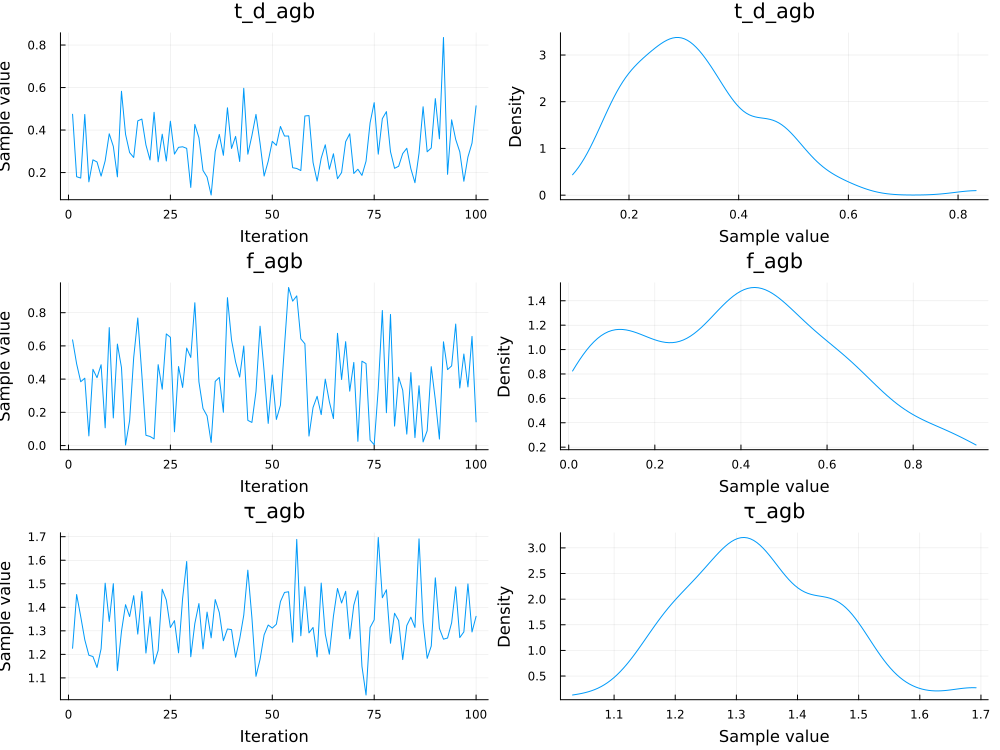

In [120]:
plot(chain)

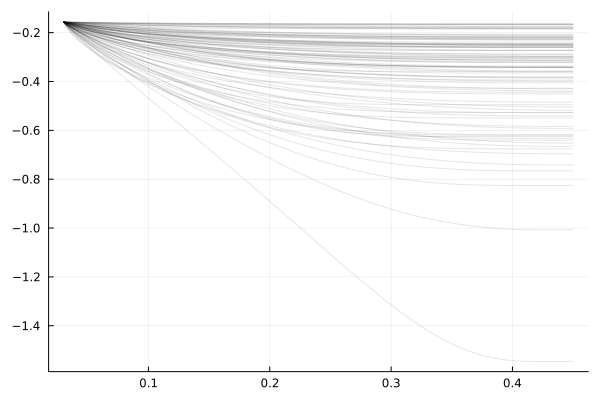

In [138]:
plot_chain(chain)

In [122]:
x = subgiants.MG_FE.values
y = subgiants.C_MG.values
σ_y = subgiants.C_MG_ERR.values 
σ_x = subgiants.MG_FE_ERR.values 

filt = (!).(isnan.(x))
filt .&= (!).(isnan.(y))
filt .&= (!).(isnan.(σ_y))
filt .&= (!).(isnan.(σ_x))

x = x[filt]
y = y[filt]
σ_y = σ_y[filt];
σ_x = σ_x[filt];

In [ ]:
model = singlezone_regression(x, y, σ_x, σ_y)
chain = sample(model, NUTS(0.65), 20)

In [ ]:
plot(chain)

In [ ]:
plot_chain(chain)